# Coordinate Conventions

A major headache during this project has been the different conventions with coordinates handling between each library. This notebook is used to document these differences for later reference.

We are going to need the following libraries:

In [2]:
from pathlib import Path

import matplotlib.pyplot as plt
import numpy as np
from skimage import measure
from skimage.measure import regionprops

The source images are in the NIfTI format. We are going to work with the first slice of the image **radiopaedia_14_85914_0.nii.gz**. This image is ideal for the task at hand, as their slices are not square, but 630 pixels width and 401 pixels height. It looks like this in [ImageJ][imagej]:

![Slice 0 of the CT **radiopaedia_14_85914_0.nii.gz**](images/ct_radiopaedia_original_imagej.png "Slice 0 of the CT **radiopaedia_14_85914_0.nii.gz**")

[imagej]: https://imagej.net/ "ImageJ is open source software for processing and analyzing scientific images"

The first slice has been saved as NumPy for ease of use. Let's load it:

In [3]:
data_folder_path = Path('data')
image_name = 'radiopaedia_14_85914_0'
slice_number = 0
image_file_path = Path(f'{image_name}_image_slice_{slice_number}.npy')
masks_file_path = Path(f'{image_name}_masks_slice_{slice_number}.npy')
image_slice_path = data_folder_path / image_file_path
masks_slice_path = data_folder_path / masks_file_path

This slice and its corresponding masks have been obtained with the notebook **get_slice.ipynb**.

Let's see the shape of the slice array loaded:

In [4]:
image_slice = np.load(image_slice_path)
image_slice.shape

(630, 401)

As we can see, the first dimension of the array matches the columns of the image, while the second matches its rows.
Now, let's take a look at the image:

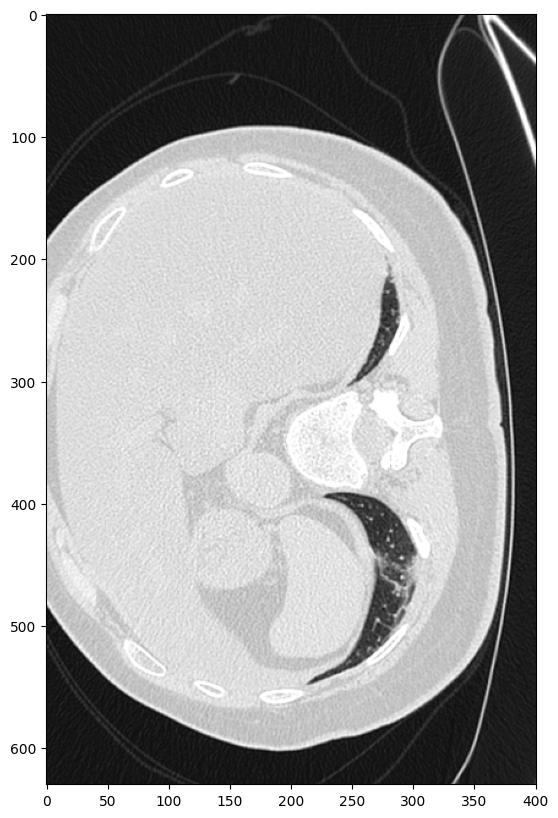

In [5]:
plt.figure(figsize=(10, 10))
plt.style.use('grayscale')
plt.imshow(image_slice)
plt.show()

Why is the image shown that way? From PyPlot's [**imshow()** documentation][imshow]:

> The first two dimensions (M, N) define the rows and columns of the image.

[imshow]: https://matplotlib.org/stable/api/_as_gen/matplotlib.pyplot.imshow.html "matplotlib.pyplot.imshow"

This means that we can show the image correctly with a simple transposition of the image's elements:

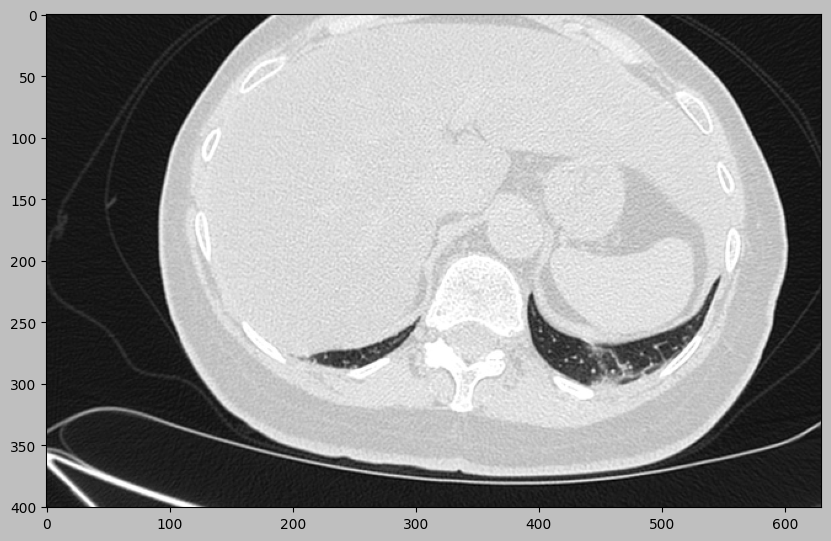

In [6]:
plt.figure(figsize=(10, 10))
plt.style.use('grayscale')
plt.imshow(image_slice.T)
plt.show()

Now, do we want to do that? Should we swim against the current, or modify the data arrangement to make our code simpler? Let's look at all the operations we will need to do. First of all, we also have the masks. Let's plot them:

In [7]:
masks_slice = np.load(masks_slice_path)
masks_slice.shape

(630, 401)

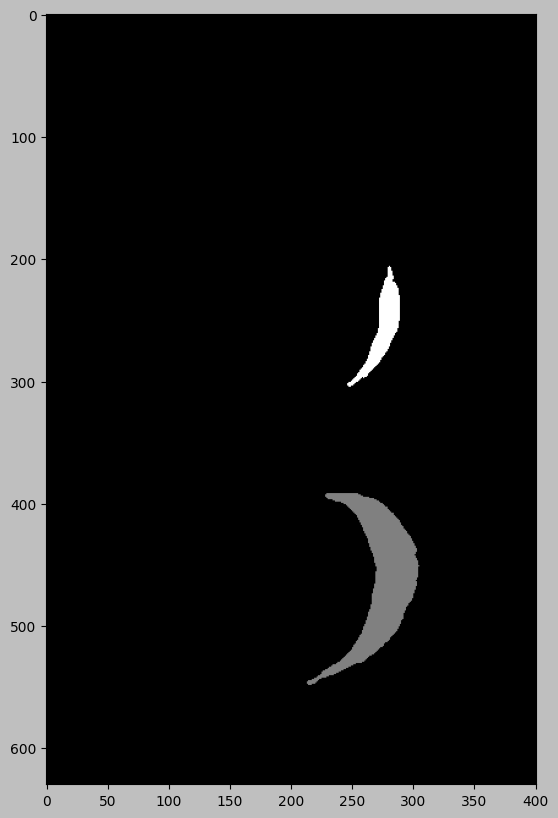

In [8]:
plt.figure(figsize=(10, 10))
plt.style.use('grayscale')
plt.imshow(masks_slice)
plt.show()

Again, we have to transpose the mask before showing it if we want to avoid tilting our head:

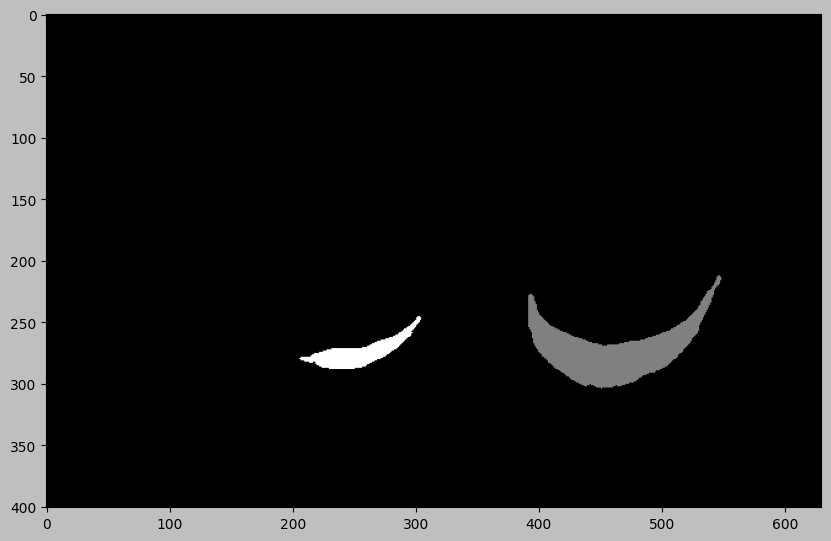

In [9]:
plt.figure(figsize=(10, 10))
plt.style.use('grayscale')
plt.imshow(masks_slice.T)
plt.show()

Now, that's a second time we have to play with coordinate's transformation.

Let's locate the center of each mask and plot masks and centers together. From [**regionproprs()** documentation][regionprops] we know that the centroid is an array with two values, that is, the row and column:

[regionprops]: https://scikit-image.org/docs/stable/api/skimage.measure.html#regionprops "regionprops"

In [10]:
regions_properties = regionprops(masks_slice)
for region_properties in regions_properties:
    print(f'region label: {region_properties.label}')
    print(f'- centroid row: {region_properties.centroid[0]}')
    print(f'- centroid column: {region_properties.centroid[1]}')

region label: 1
- centroid row: 460.3869126043039
- centroid column: 272.8025911286781
region label: 2
- centroid row: 254.97427385892115
- centroid column: 274.9219917012448


Now, let's plot the centroids using **plot()**. From [its documentation][plot] we know that it expects the x and y coordinates of a given point.

[plot]: https://matplotlib.org/stable/api/_as_gen/matplotlib.pyplot.plot.html "matplotlib.pyplot.plot"

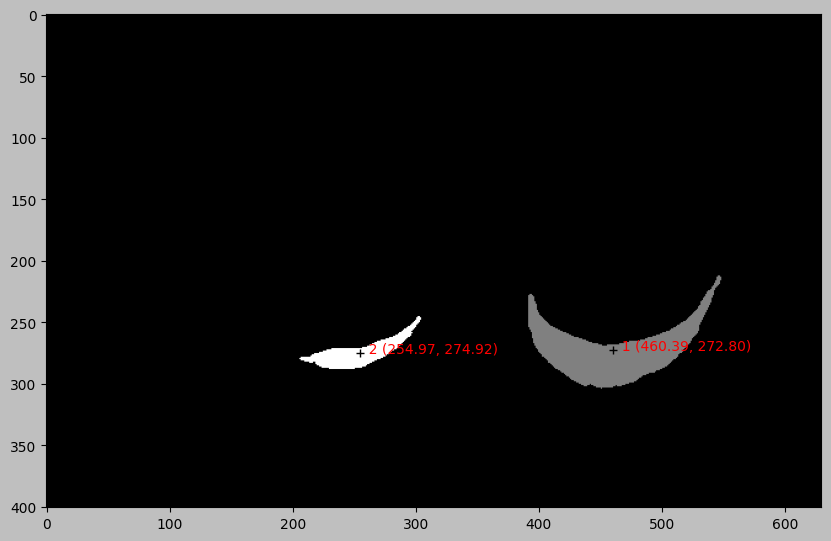

In [11]:
plt.figure(figsize=(10, 10))
plt.style.use('grayscale')
plt.imshow(masks_slice.T)
for region_properties in regions_properties:
    label = region_properties.label
    centroid = region_properties.centroid[0], region_properties.centroid[1]
    plt.plot(centroid[0], centroid[1], marker='+', color='black')
    plt.annotate(f'  {label} ({centroid[0]:.2f}, {centroid[1]:.2f})', xy=centroid, color='red')
plt.show()

In this case, we didn't need to make any transformation. The centroids' coordinates are in column, row format (x and y), and **plot()** expects them that way.

Let's try now to look for the contours of each mask. In this case, there are two regions, one for each lung. However, it could be the case that one lung showed more than one region. That's the case in the sixth slice of the same image, in the right lung:

![Slice 6 of the CT **radiopaedia_14_85914_0.nii.gz**](images/ct_radiopaedia_image_14_slice_6_original_two_regions_imagej.png "Slice 6 of the CT **radiopaedia_14_85914_0.nii.gz**")

Let's find the different contours:

In [12]:
contours = []
for region_properties in regions_properties:
    mask = masks_slice == region_properties.label
    mask_contours = measure.find_contours(mask)
    for mask_contour in mask_contours:
        contours.append(mask_contour)

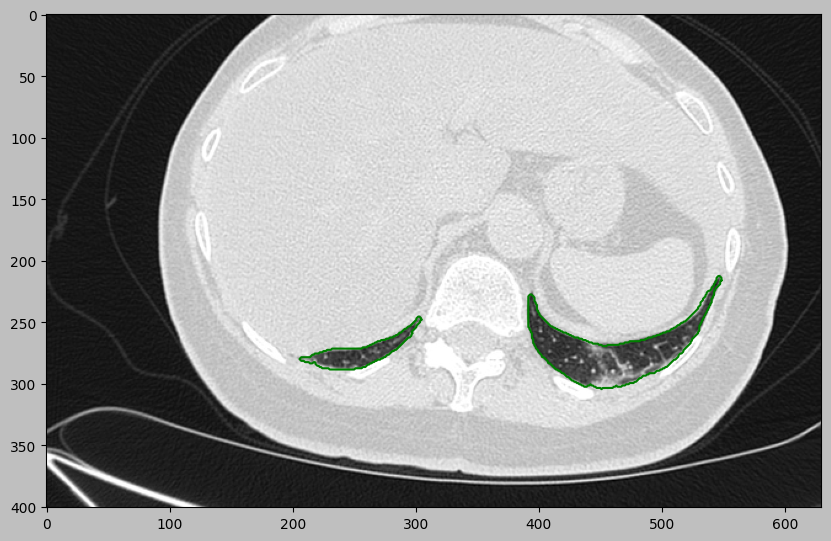

In [13]:
plt.figure(figsize=(10, 10))
plt.style.use('grayscale')
plt.imshow(image_slice.T)
for contour in contours:
    plt.plot(contour[:, 0], contour[:, 1], color='green')

Great, right? **NO!** If we take a look at [**find_contours()** documentation][find_contours] we will notice a couple of things. First of all, the contours are a list of row and column coordinates. "But they look perfect in the image! How is it possible?" That's because we've provided an array of columns and rows, and [skimage expected them to be rows and columns][coordinate_conventions]. As a result, when we show it they are perfect, but not knowing it can be a source of problems, because data are not in the format we expected.

So, if we want to be precise with our calculations and avoid lots of bumps and headaches in the way forward, we need to make some changes on how we look for the contours:

[find_contours]: https://scikit-image.org/docs/stable/api/skimage.measure.html#find-contours "find_contours"
[coordinate_conventions]: https://scikit-image.org/docs/dev/user_guide/numpy_images.html#coordinate-conventions "Coordinate conventions"

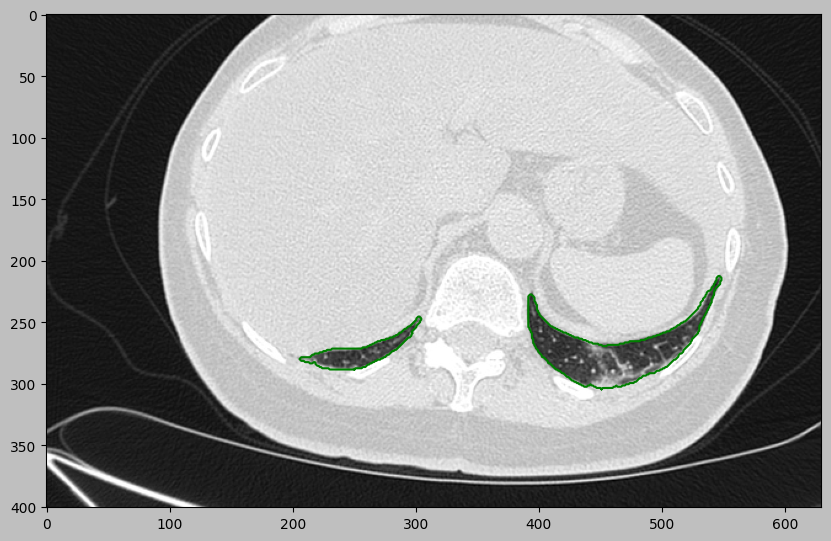

In [14]:
contours = []
for region_properties in regions_properties:
    mask = masks_slice == region_properties.label
    # This switches rows for columns
    mask_contours = measure.find_contours(mask.T)
    for mask_contour in mask_contours:
        contours.append(mask_contour)

plt.figure(figsize=(10, 10))
plt.style.use('grayscale')
plt.imshow(image_slice.T)
for contour in contours:
    # Contours contains rows (y) in the first index, columns (x) in the second
    plt.plot(contour[:, 1], contour[:, 0], color='green')

Why is this swap so important? Because when showing them on screen it seems to be no difference, but in reality coordinates are not where we expect them to be, leading to unexpected consequences.

Now, for the last experiment. Let's draw the bounding box of each contour:

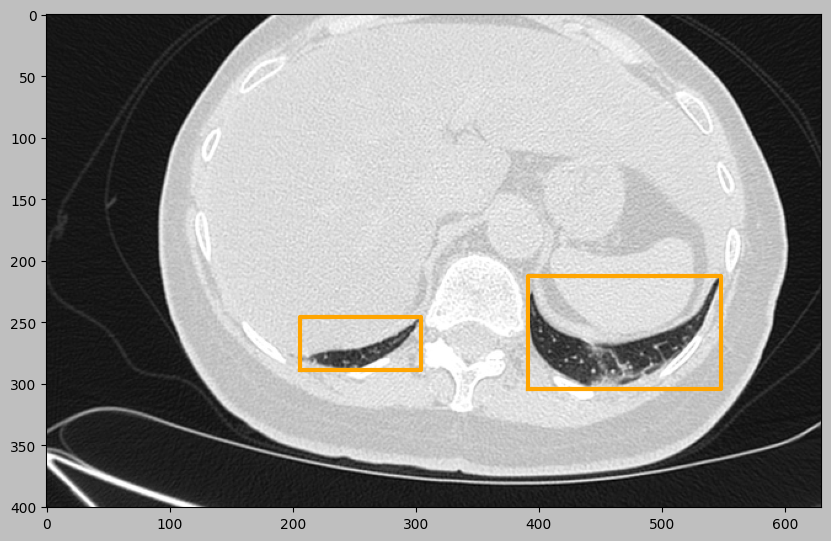

In [15]:
bounding_boxes = []
for contour in contours:
    # Remember: contours are in the form row (y), column (x)
    x_min = np.min(contour[:, 1])
    x_max = np.max(contour[:, 1])
    y_min = np.min(contour[:, 0])
    y_max = np.max(contour[:, 0])
    bounding_boxes.append([x_min, x_max, y_min, y_max])

plt.figure(figsize=(10, 10))
plt.style.use('grayscale')
plt.imshow(image_slice.T)
for bounding_box in bounding_boxes:
    xs = [bounding_box[0],
          bounding_box[1],
          bounding_box[1],
          bounding_box[0],
          bounding_box[0]]
    ys = [bounding_box[3],
          bounding_box[3],
          bounding_box[2],
          bounding_box[2],
          bounding_box[3]]
    plt.plot(xs, ys, color='orange', linewidth=3)

Good job! But take a look at the mess above. Besides having to transpose the array before plotting it, inside the loop to calculate the bounding boxes we've been assigning the index 1 to the x variables, something that could lead to errors down the road.

In summary, in this particular project it could be better to:

1. Change the frame of reference, transposing both the slices (image and masks) before saving them to NumPy arrays, and
2. Stop working with x and y, and start working with rows and columns.

And that's exactly what we have decided to do.

This could also be a good idea for future image-related projects. In any case, don't make any suppositions and read the documentation of the libraries you are going to use.
